## Predict perturbation difficulties on the Wang 2015 set 

In [1]:
from sklearn import preprocessing, decomposition
import pickle
import pandas as pd
import glob
import hydra_features
import hydra_labels
import hydra_utils
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
import numpy as np 
import matplotlib.pyplot as plt
#import seaborn as sns
from mordred import Calculator, descriptors
from scipy import stats
from sklearn.metrics import mean_absolute_error

# TF-related imports & some settings to reduce TF verbosity:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"	# current workstation contains 4 GPUs; exclude 1st
import tensorflow as tf 
from tensorflow import keras
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
def computeStats(x, y):
	pearsonr = round(stats.pearsonr(x, y)[0], 3)
	tau = round(stats.kendalltau(x, y)[0], 3)
	mae = round(mean_absolute_error(x, y), 3)

	return pearsonr, tau, mae

In [3]:
	def molToAPFP(mol):
		# create atom-pair bitstring of 256 bits 
	    mol.UpdatePropertyCache(strict=False)
	    FP = rdMolDescriptors.GetHashedAtomPairFingerprint(mol, 256)

	    # convert to array:
	    FP = np.array(list(FP))
	    return FP

In [4]:
# glob over test set folders
testset_input = {}
cong_sets = glob.glob("TESTSETS/wang15/*/")
for cong_set in cong_sets:
    testset_input[cong_set.split("/")[2]] = glob.glob(cong_set+"*MBAR.dat")

In [10]:
# read which molecular properties to generate based on training set:
target_column_names = pd.read_csv("features/MOLPROPS/free_featurised.csv").columns.values[1:].tolist()
calc = Calculator(descriptors, ignore_3D=False)

# grab scaler and PCA objects:
path_to_scaler_pickle_molprops = "trainingsets_prepared/PICKLES/MOLPROPS_scaler.pkl"
path_to_pca_pickle_molprops = "trainingsets_prepared/PICKLES/MOLPROPS_pca.pkl"
scaler_molprops = pickle.load(open(path_to_scaler_pickle_molprops, "rb"))
pca_molprops = pickle.load(open(path_to_pca_pickle_molprops, "rb"))

path_to_scaler_pickle_apfp = "trainingsets_prepared/PICKLES/PFP_scaler.pkl"
path_to_pca_pickle_apfp = "trainingsets_prepared/PICKLES/PFP_pca.pkl"
scaler_apfp = pickle.load(open(path_to_scaler_pickle_apfp, "rb"))
pca_apfp = pickle.load(open(path_to_pca_pickle_apfp, "rb"))

# grab pre-trained model:
arch = "models/MOLPROPS_HYDRA_architecture.json"
weights = "models/MOLPROPS_HYDRA_weights.h5"

# use standard keras loading from disk procedure:
with open(arch) as json_file:
    json_config = json_file.read()
keras_model = keras.models.model_from_json(json_config)
keras_model.load_weights(weights)

testset_data_bucket_molprops = pd.DataFrame()
testset_data_bucket_apfp = pd.DataFrame()
prediction_bucket = []

# take information from each MBAR output:
for tgt, mbar_paths in testset_input.items():
    print("Working on", tgt)
    mol_paths = glob.glob("TESTSETS/wang15/"+tgt+"/*.pdb")
    mols = [ hydra_utils.retrieveMolecule(mol) for mol in mol_paths if not "protein" in mol]
    mol_names = [ path.replace("TESTSETS/wang15/"+tgt+"/", "").replace(".pdb","") for path in mol_paths if not "protein" in path]
    
    # Molprops:
    molprops_df = calc.pandas(mols)[target_column_names]
    molprops_df.index = mol_names
    
    # APFP:
    apfp_df = pd.DataFrame()
    for mol, name in zip(mols, mol_names):
        mol_fp = molToAPFP(mol)
        apfp_df = pd.concat([apfp_df, pd.DataFrame([mol_fp], index=[name])]) 
    
    

    # with molprops computed per ligand; process each perturbation: 
    for mbar_path in mbar_paths:
        pert = mbar_path.split("/")[3].split(".")[0]
        ligA, ligB = pert.split("~")
        system = mbar_path.split("/")[3].split(".")[1]
        
        # compute labels:
        overlap_matrix, OS, MBAR_freenrg, MBAR_error = hydra_labels.retrieveMBAROutput(mbar_path)
        
        ##### Molprops:
        # compute features & preprocess:        
        ligA_molprops = molprops_df.loc[ligA]
        ligB_molprops = molprops_df.loc[ligB]
        pert_molprops = pd.DataFrame(ligB_molprops.subtract(ligA_molprops)).transpose()
        
        # scale and PCA:
        pert_data_scaled_molprops = scaler_molprops.transform(pert_molprops)
        pert_data_processed_molprops = pca_molprops.transform(pert_data_scaled_molprops)
        pert_data_df_molprops = pd.DataFrame(pert_data_processed_molprops, index=[tgt+"_"+pert])
        pert_data_df_molprops["OS"] = OS
        
        #### APFP:
        # compute features & preprocess:        
        ligA_apfp = apfp_df.loc[ligA]
        ligB_apfp = apfp_df.loc[ligB]
        pert_apfp = pd.concat([ligB_apfp, ligA_apfp]).to_frame(name=pert).transpose()
        
        # scale and PCA:
        pert_data_scaled_apfp = scaler_apfp.transform(pert_apfp)
        pert_data_processed_apfp = pca_apfp.transform(pert_data_scaled_apfp)
        pert_data_df_apfp = pd.DataFrame(pert_data_processed_apfp, index=[tgt+"_"+pert])
        pert_data_df_apfp["OS"] = OS
        
        testset_data_bucket_molprops = pd.concat([testset_data_bucket_molprops, pert_data_df_molprops])
        testset_data_bucket_apfp = pd.concat([testset_data_bucket_apfp, pert_data_df_apfp])
        
        
#         # predict:
#         pred = keras_model.predict(pert_data_processed)[0]
        
#         # build dict:
#         prediction_bucket.append([tgt, pert, float(pred), OS]) 
testset_data_bucket_molprops.to_csv("TESTSETS/wang15/fullset_preprocessed_molprops.csv")
testset_data_bucket_apfp.to_csv("TESTSETS/wang15/fullset_preprocessed_apfp.csv")
testset_data_bucket_apfp

Working on thrombin


100%|██████████| 11/11 [00:01<00:00,  7.83it/s]


Working on p38


100%|██████████| 39/39 [00:04<00:00,  9.66it/s]


Working on cdk2


100%|██████████| 18/18 [00:02<00:00,  8.94it/s]


Working on bace


100%|██████████| 39/39 [00:03<00:00, 10.43it/s]


Working on mcl1


100%|██████████| 43/43 [00:03<00:00, 10.91it/s]


Working on ptp1b


100%|██████████| 25/25 [00:02<00:00,  8.40it/s]


Working on tyk2


100%|██████████| 17/17 [00:01<00:00, 10.54it/s]


Working on jnk1


100%|██████████| 21/21 [00:02<00:00,  9.92it/s]


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,OS
thrombin_3a~3b,283.470303,-121.620746,20.647271,-73.319987,354.718113,102.220920,51.754646,136.143553,197.724627,131.832846,...,-6.086053,18.179591,-24.267741,-23.137663,-13.399470,37.214368,-10.212035,-0.420440,-25.041414,0.206000
thrombin_6e~6a,303.251949,-121.028479,29.008829,-90.694606,393.439385,103.853744,85.426175,114.089430,214.622316,164.155593,...,-14.924977,9.294773,-20.422252,-32.457793,-17.723753,50.072758,-23.645327,12.342951,-14.259812,0.245525
thrombin_6a~6b,308.559843,-131.852892,14.844009,-74.391708,387.714173,96.756330,71.928025,131.387137,210.815633,174.106578,...,-12.169486,16.286633,-11.185608,-29.059458,1.212495,43.245099,-24.001052,8.605864,-17.148094,0.221488
thrombin_6b~1b,286.543145,-120.156830,18.158109,-77.399573,398.256882,98.929656,63.723826,141.230784,215.558051,164.148604,...,-8.013178,18.383471,-4.931035,-28.995187,-5.652188,45.104646,-30.119144,10.132052,-22.996033,0.203387
thrombin_5~3a,289.755759,-135.900647,9.274955,-55.048832,378.188966,76.339373,57.938113,129.549399,210.001512,153.839702,...,-18.726769,15.988196,-22.196253,-27.575352,-10.794407,41.807311,-10.427993,-6.394210,-24.076686,0.216200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jnk1_18630-1~18624-1,188.353443,-58.224994,5.039434,-56.744245,210.947201,97.909002,-43.791271,74.127818,149.356092,65.177192,...,3.220670,30.343704,-26.476386,7.009946,-17.909690,27.690614,-47.174152,-8.292849,-47.763816,0.216388
jnk1_18635-1~18629-1,183.707747,-51.977745,-4.007642,-54.011181,219.621815,99.439772,-31.986453,74.347630,141.101350,73.601496,...,7.473882,32.336964,-24.505159,2.379109,-29.266884,31.001880,-43.875689,-11.384022,-59.328138,0.202750
jnk1_18629-1~18624-1,164.460072,-45.598130,4.392505,-58.633799,173.861069,102.359066,-42.440360,67.113779,137.800497,37.985150,...,2.357535,29.811360,-29.989004,14.123022,-21.068482,24.002341,-38.187157,-11.773670,-56.208165,0.214875
jnk1_18637-1~17124-1,290.944663,-57.857780,11.366942,-104.881119,260.983500,192.976616,-79.913510,65.148736,128.162295,121.126743,...,23.229940,42.296535,-9.394960,7.084127,5.829460,37.164029,-46.261877,30.644604,-39.338875,0.173200


In [15]:
# validate predictions
predictions_df = pd.DataFrame.from_records(prediction_bucket, columns=["target", "pert", "predicted_OS", "simulated_OS"])

pearsonr, tau, mae = computeStats(predictions_df["predicted_OS"], predictions_df["simulated_OS"])
print("Pearson r:", round(pearsonr, 2))
print("MUE:", round(mae, 2))
print("Kendall tau:", round(tau, 2))

Pearson r: 0.23
MUE: 0.22
Kendall tau: 0.18


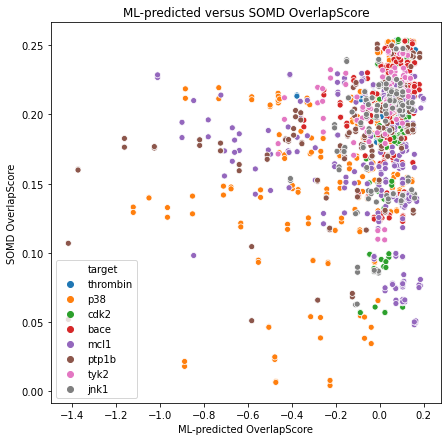

In [28]:
# color scatterplot by target -> any bad targets? all bad? particularly difficult perts?
plt.figure(figsize=(7,7))
plt.title("ML-predicted versus SOMD OverlapScore")
sns.scatterplot("predicted_OS", "simulated_OS", hue="target", data=predictions_df)
plt.xlabel("ML-predicted OverlapScore")
plt.ylabel("SOMD OverlapScore")
plt.show()